<a href="https://colab.research.google.com/github/zhifengyang-ou/Predict_dynamics/blob/main/read_output_of_TabSurvey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
file_x="/content/gdrive/MyDrive/Colab Notebooks/DARPA project/Ocean01/Ocean01A1.Env.fillna.csv"
file_y="/content/gdrive/MyDrive/Colab Notebooks/DARPA project/Ocean01/Ocean01A1.ASV.Top100.csv"

env=pd.read_csv(file_x)
asv=pd.read_csv(file_y)
envnp=env[env.columns[1:]].to_numpy(dtype='float32')
asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T
train_X,test_X=envnp[:80,],envnp[80:,]
train_y,test_y=asvnp[:80,],asvnp[80:,]
scaler = StandardScaler()
train_X= scaler.fit_transform(train_X)
test_X=scaler.transform(test_X)

In [42]:
!pip install optuna

In [43]:
import optuna
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DARPA project/notebook/TabSurvey-main/TabSurvey-main')

load_study=optuna.load_study(study_name="MLP_Ocean_microbe", storage="sqlite:///MLP_Ocean_microbe.db")

In [44]:
optuna.visualization.plot_optimization_history(load_study)


In [ ]:
import torch
from models.mlp import MLP
import yaml
with open('config/Ocean_microbe.yml') as file:
    args = yaml.safe_load(file)
class MyObject:
  def __init__(self, d=None):
    if d is not None:
      for key, value in d.items():
        setattr(self, key, value)
args=MyObject(args)

In [ ]:
model=MLP(load_study.best_params,args)
model.model.load_state_dict(torch.load('output/MLP/Ocean_microbe/models/m_0.pt',map_location=torch.device('cpu')))

On Device: cpu


<All keys matched successfully>

In [ ]:
test_y_predicted=model.predict(test_X)

In [ ]:
test_y_predicted

array([[170.29733  , 253.62563  , 224.79022  , ...,   5.9140873,
         23.97688  ,  11.240546 ],
       [503.86353  , 158.33316  , 115.4212   , ...,   1.7076485,
          9.429073 ,   4.056336 ],
       [479.9929   , 102.009964 ,  91.01692  , ...,  -0.6317795,
          7.6661983,   3.9545126],
       ...,
       [329.91113  , 128.87051  , 116.99289  , ...,   2.686241 ,
         10.336842 ,  12.211326 ],
       [149.89511  , 140.88031  , 110.872986 , ...,   3.7799916,
         11.102453 ,  14.343825 ],
       [266.2075   , 132.87424  , 107.569565 , ...,  -3.4266136,
         11.822824 ,  10.365136 ]], dtype=float32)

In [ ]:
def acc(ytrue,ypred):
    """ return accuracy = Ca, precision = r, ccc = rc"""
        y=ypred.reshape(-1,1)
        x=ytrue.reshape(-1,1)
        d = y - x
        m1 = np.mean(y)
        m2 = np.mean(x)
        v1 = np.var(y)
        v2 = np.var(x)
        n = len(d)
        e2 = np.sum(d*d)/n
        mu_d = m1 - m2
        d2 = mu_d**2
        s12 = v1
        s22 = v2 ## var is different for R and python
        U = mu_d/np.sqrt(np.sqrt(s12 * s22))
        V = np.sqrt(s12/s22)
        Ca = 2/(V + 1/V + U**2)
        rc = 1 - e2/(d2 + s12 + s22)
        r = (rc/Ca)
        return Ca, r, rc

def precision(ytrue,ypred):
        y=tf.reshape(ypred,[-1])
        x=tf.reshape(ytrue,[-1])
        d = y - x
        m1 = tf.reduce_mean(y)
        m2 = tf.reduce_mean(x)
        v1 = tf.math.reduce_variance(y)
        v2 = tf.math.reduce_variance(x)
        e2 = tf.reduce_mean(d*d)
        mu_d = m1 - m2
        d2 = mu_d**2
        s12 = v1
        s22 = v2 ## var is different for R and python
        U = mu_d/tf.math.sqrt(tf.math.sqrt(s12 * s22))
        V = tf.math.sqrt(s12/s22)
        Ca = 2/(V + 1/V + U**2)
        rc = 1 - e2/(d2 + s12 + s22)
        r = (rc/Ca)
        return -tf.math.minimum(r,Ca)

IndentationError: ignored

In [ ]:
acc(test_y,test_y_predicted),acc(train_y, model.predict(train_X))


((0.5700464520955156, 0.0, -0.09983715862503229),
 (0.8946378107536533, 0.0, 0.605272217009036))

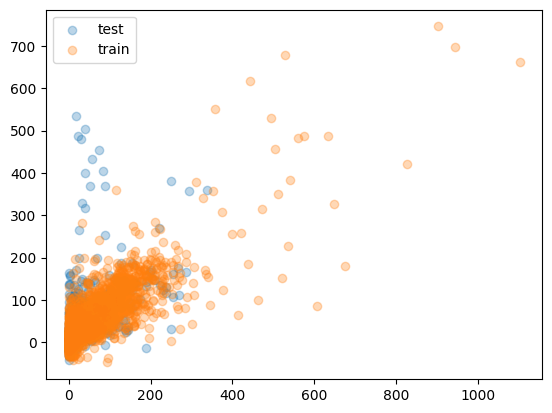

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(test_y,test_y_predicted,label="test",alpha=0.3)
plt.scatter(train_y, model.predict(train_X),label="train",alpha=0.3)
plt.legend()

In [ ]:
import pandas as pd
model = pd.read_pickle(r'output/RandomForest/Ocean_microbe/models/m_1.pkl')